# Dogs vs. cats classification
IFT6135 - Winter 2019

Assigment 1 - Problem 3

Authors: <br>
Stephan Tran <br>
Oussema Keskes <br>
Stefan Wapnick <br>
Mohamed Amine <br>

Kaggle Team name: Doge

Inspired by the IFT6135-H19 PyTorch Tutorial

## Importing libraries

In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import csv
import os
import pandas as pd
from IPython.display import display, Markdown

## Defining paremeters and variables

In [ ]:
RUN_LOCAL = True
VALID_RATIO = 0.10
TRAIN_RATIO = 1.0 - VALID_RATIO
LEARNING_RATE = 0.00001
KERNEL_SIZE = 3
PAD = 1
BATCH_SIZE = 128
MAX_EPOCH = 186

SAVE_MODEL = False  # Save model after each epoch
LOAD_MODEL = False # Skip training phase
SAVE_PATH = 'BestModel.pwf'

if RUN_LOCAL:
    TRAIN_IMG_DIR ='trainset/trainset'
    TEST_IMG_DIR = 'testset/'
else:
    # Kaggle directory
    TRAIN_IMG_DIR ='../input/trainset/trainset'
    TEST_IMG_DIR = '../input/testset'

cuda_available = torch.cuda.is_available()
# print(cuda_available)

## Importing datasets and preprocessing
1. Load training and testing images
2. Data augmentation: <br>
    In order to learn features from various images of position of dog and cats, we have augmented the dataset examples with<br>
    a) __Horizontal flipping__: the input image is randomly mirrored so the model could learn features of a dog or cat even if it is flipped. 
    The dog shown in the left side below and the right side below should both be recognised as a dog by the model. <br>
    
    ![](figures/dog.jpg)
    ![](figures/dog_flip.jpg)
    
    b) __Rotation__: Similarily to the horizontal flipping process, we have added random rotation (up 10 degrees roration) to the training set to learn features of a dog or
    cat no matter how it is oriented. This is meant to make the model able to recognize a dog or cat even if it is slighty rotated. <br>
    
    ![](figures/dog.jpg)
    ![](figures/dog_rot.png)
    
    c) __Random resize and scale__: the training images have been cropped and then rescale back to the original size. The purpose of the operation is to build some invariance
    to scaling of dogs and cats features in our model. <br>
    
    ![](figures/dog.jpg)
    ![](figures/dog_resize.png)
    
3. Transform images into tensor so they could be processed
4. __Split dataset into training and validation set__:
    To determine the appropriate the hyperparameters (number of convoution layers, kernel size, learning rate, choice of activation function, etc.) for the current task, we
    have split the initial training set into a final training set and a validation set with a ratio of 90 % and 10 % respectively. This way, we should be able to have enough
    training examples to learn the features and enough validation set examples so the result of the validation can be considered a good representation of unknown inputs (test
    set). In this case, we have: <br>
    - Training set total examples		: 19,998 items <br>
    - Training set after split (90%)	: 17,999 items <br>
    - Validation set after split (10%)	:  1,999 items <br>

In [11]:
# Class to return image folder with paths inspired from andrewjong
class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

# Apply a combination of transforms on all images
image_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(64, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.48,0.45,0.40), (0.20,0.20,0.20))
])

# No transforms on the image
image_transform_test = transforms.Compose([  
    transforms.ToTensor(),
    transforms.Normalize((0.48,0.45,0.40), (0.20,0.20,0.20))
])

train_dataset = datasets.ImageFolder(root=TRAIN_IMG_DIR, transform=image_transform)
valid_dataset = datasets.ImageFolder(root=TRAIN_IMG_DIR, transform=image_transform_test)

# Dataset splitting (train-validation)
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(VALID_RATIO * dataset_size))

np.random.seed(42)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


# Load dataset
trainset_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE,
                                             num_workers=4, sampler=train_sampler)

validset_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = 1,
                                             num_workers=4, sampler=valid_sampler)


test_dataset = ImageFolderWithPaths(root=TEST_IMG_DIR, transform=image_transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False,
                                              num_workers=4)


# Showing some samples of the training set

In [12]:
def imshow(img):
    x, y = img
    x = x.numpy().transpose((1, 2, 0))
    print(x.shape)
    plt.imshow(x)
    if y == 0:
        print('Meow!')
    else:
        print('Barf!')

# plt.figure()  
# plt.subplot(1,2,1)
# imshow(train_dataset[800])
# plt.subplot(1,2,2)
# imshow(valid_dataset[100])

def get_mean_std(dataset):
    r_mean_list = []
    g_mean_list = []
    b_mean_list = []
    r_std_list = []
    g_std_list = []
    b_std_list = []
    
    for i in range(100):
        x = dataset[10*i][0]
        x = np.asarray(x)
        r_mean, g_mean, b_mean = np.mean(x[0]), np.mean(x[1]), np.mean(x[2])
        r_std,g_std,b_std = np.std(x[0]), np.std(x[1]), np.std(x[2])
        
        r_mean_list.append(r_mean)
        g_mean_list.append(g_mean)
        b_mean_list.append(b_mean)
        r_std_list.append(r_std)
        g_std_list.append(g_std)
        b_std_list.append(b_std)
        
    print(dataset[100][0])
    
    mean = [np.mean(r_mean_list), np.mean(g_mean_list), np.mean(b_mean_list)]
    std = [np.mean(r_std_list), np.mean(g_std_list), np.mean(b_std_list)]        
    
    return mean, std
        
# print(get_mean_std(train_dataset))

## Defining CNN architecture
We use a CNN which is inspired from VGGNet model with 4 convolution layers, a ReLU activation function after each convolution stage followed by max pooling layers from beginning to end and 3 fully connected linear layers as shown in the output below. Here are additional description of the model:
- The size of the convolutional filters is (3x3) with padding p= 1
- Max pooling windows is (2, 2) with stride s=2. 
- The output activation function is a sigmoid so we can have an output ranging from [0,1]
- The total number of parameters is 4846401. 
- Optimizer: Stochastic Gradient Descent with a learning rate of 0.00001
- Loss Function: Binary Cross Entropy
- The batch size is 128
- The number of epochs is 186


In [18]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            # Layer 1: Convolution - ReLU - Max pooling
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(KERNEL_SIZE, KERNEL_SIZE), padding=PAD),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2: Convolution - ReLU - Max pooling
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(KERNEL_SIZE, KERNEL_SIZE), padding=PAD),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3: Convolution - ReLU - Max pooling
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(KERNEL_SIZE, KERNEL_SIZE), padding=PAD),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4: Convolution - ReLU - Max pooling
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(KERNEL_SIZE, KERNEL_SIZE), padding=PAD),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
                     
        )        
        # Layer 5-6-7: Fully connected linear layers
        self.fc1 = nn.Linear(256*4*4, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 1)

        
    def forward(self, x):
        temp = self.conv(x)
        temp = temp.view(-1,256*4*4)
        temp = self.fc1(temp)
        temp = self.fc2(temp)
        temp = self.fc3(temp)
        temp = torch.sigmoid(temp)
        return temp
    
cnn = Classifier()
if cuda_available:
    cnn = cnn.cuda()

optimizer = torch.optim.SGD(cnn.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()

pytorch_total_params = sum(p.numel() for p in cnn.parameters())
print('Number of parameters in the model: %d' % pytorch_total_params)
print(cnn)

Number of parameters in the model: 4846401
Classifier(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


# Classifier training and validation

In [ ]:
best_epoch = 0
best_acc = 0
log_train_loss = []
log_train_acc = []
log_valid_loss = []
log_valid_acc = []

if LOAD_MODEL == False:
    for epoch in range(MAX_EPOCH):

        train_losses = []
        valid_losses = []

        total = 0
        correct = 0

        ##### TRAINING PHASE ####
        # Set the model in training mode  
        for batch_idx, (inputs, labels) in enumerate(trainset_loader):

            # Data conversion to float and cuda
            labels_flt = torch.tensor(labels, dtype=torch.float)
            if cuda_available:
                inputs, labels_flt, labels = inputs.cuda(), labels_flt.cuda(), labels.cuda()

            # Compute forward phase
            outputs = cnn(inputs).squeeze()

            # Compute training loss (Binary Cross Entropy)
            loss = criterion(outputs, labels_flt)
            train_losses.append(loss.data.item())
            
            # Prediction: since the output is between 0 and 1 du to sigmoid activation function, the
            # prediction value will be 0 when the output is [0,0.5] and 1 when it is ]0.5,1]
            predicted = outputs > 0.5
            if cuda_available:
                predicted = torch.tensor(predicted, dtype=torch.long).cuda()
            else:
                predicted = torch.tensor(predicted, dtype=torch.long)

            # Compute training accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            train_acc = 100*correct/total

            # Backward propagation
            loss.backward()
            optimizer.step()

        # Log the training loss and accuracy with respect to the epoch number
        log_train_loss.append([epoch,np.mean(train_losses)])
        log_train_acc.append([epoch,train_acc])

        # Save model into a file for later use
        if SAVE_MODEL:
            if epoch%5 == 0:
                torch.save(cnn.state_dict(), "CNN{0:03d}.pwf".format(epoch)) 


        ##### VALIDATION PHASE ####
        total = 0
        correct = 0    

        # Set the model in evaluation mode
        with torch.no_grad():    
            for batch_idx, (inputs, labels) in enumerate(validset_loader):
                # Data conversion to float and cuda
                labels_flt = torch.tensor(labels, dtype=torch.float)
                if cuda_available:
                    inputs, labels_flt, labels = inputs.cuda(), labels_flt.cuda(), labels.cuda()

                # Compute forward phase
                outputs = cnn(inputs).squeeze()   

                # Compute validation loss (Binary Cross Entropy)
                loss = criterion(outputs, labels_flt)
                valid_losses.append(loss.data.item())        

                # Prediction
                predicted = outputs > 0.5
                predicted = torch.tensor(predicted, dtype=torch.long).cuda()

                # Compute training accuracy
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                valid_acc = 100*correct/total

        # Log the training loss and accuracy with respect to the epoch number
        log_valid_loss.append([epoch,np.mean(valid_losses)])
        log_valid_acc.append([epoch,valid_acc])

        if valid_acc > best_acc:
            best_epoch = epoch
            best_acc = valid_acc      
        
    log_train_loss = np.swapaxes(np.asarray(log_train_loss),0,1)
    log_train_acc = np.swapaxes(np.asarray(log_train_acc),0,1)
    log_valid_loss = np.swapaxes(np.asarray(log_valid_loss),0,1)
    log_valid_acc = np.swapaxes(np.asarray(log_valid_acc),0,1)

    print(Test Acc : %.3f Best epoch: %d Best acc: %.3f' % (epoch, valid_acc , best_epoch, best_acc))
    print('------------------------------------------------------------------------------------')
else:
    cnn.load_state_dict(torch.load(SAVE_PATH))
    cnn.eval()

## Plot training and validation loss/accuracy

** Refer to curves below **

The first trend we can observe is the more training epochs we execute the more the accurate the training and validation are until a certain point. However, as we could see from the validation loss curve, the model starts to overfit on the training set after about 225 epochs. This is because the neural network is now modeled after the training set which degrades generalization perfgormance of the network.

Also, we can see a spike in the training loss and validation loss at about epoch 180. This may be due to an explosion of the gradient somehow. The model then converges back to a suboptimal point in epoch ~ 210.

In order to improve our validation performance and hopefully the test accuracy, we could have added some regularization techniques in the process so our model could be better at generalization. For example, we could have implementend
- Dropout: randomly removing some nonoutput units during training phase. This way, the learned  features could be spread across more neurons instead of being “concentred” in certain neurons in the network.
- L1 or L2 regularization: adding a regularizer term in the objective function to “penalize” the weight.

We obtained the best accuracy in validation of about 84.75% with the hyperparameters described in 3.1.  Then, we submitted our model to the test set which results in a score of 85.74%. From these numbers, we can suggest that the validation process was good enough so we could have a similar performance with the test set. Our model was able to generalize to the test examples and didn’t overfit either to the training set or the validation set.

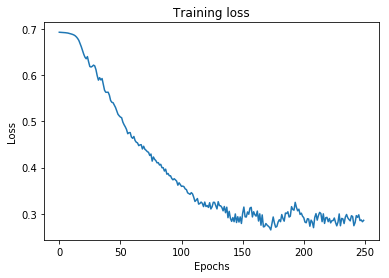

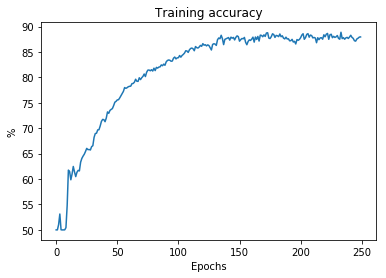

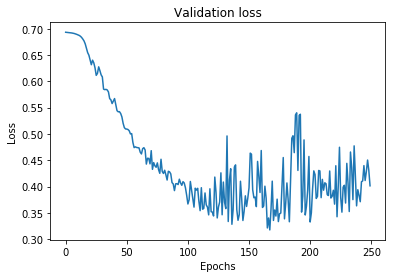

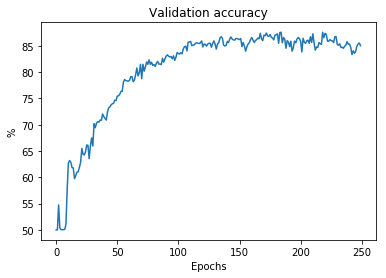

In [22]:
if LOAD_MODEL == False:
    plt.figure(1)
    plt.plot(log_train_loss[0], log_train_loss[1])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training loss')
    plt.savefig('train_loss.png')
    
    plt.figure(2)
    plt.plot(log_train_acc[0], log_train_acc[1])
    plt.xlabel('Epochs')
    plt.ylabel('%')
    plt.title('Training accuracy')
    plt.savefig('train_acc.png')

    plt.figure(3)
    plt.plot(log_valid_loss[0], log_valid_loss[1])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation loss')
    plt.savefig('valid_loss.png')

    plt.figure(4)
    plt.plot(log_valid_acc[0], log_valid_acc[1])
    plt.xlabel('Epochs')
    plt.ylabel('%')
    plt.title('Validation accuracy')
    plt.savefig('valid_acc.png')
    
    plt.show()


## Hyperparameters search
We added another linear layer and keep the other hyperparameters as is, we get:<br>

![](figures/cnn_2.png)
![](figures/train_valid_cnn_2.jpg)    
    
We also tried to increase the value of learning rate (Learning rate = 0.001) by keeping the other hyperparameters. <br>

![](figures/train_valid_cnn_3.jpg)

## Predicting test dataset

In [ ]:
header = ['id', 'label']
prediction = []

with torch.no_grad(): 
    for batch_idx, (inputs, labels, paths) in enumerate(test_loader):
        if cuda_available:
            inputs, labels = inputs.cuda(), labels.cuda()   
        outputs = cnn(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted = outputs > 0.5
        predicted = torch.tensor(predicted, dtype=torch.long).cuda()    

        filename = os.path.basename(paths[0])
        filename = os.path.splitext(filename)[0]

        if predicted == 0:
            data_out = [filename, 'Cat']
        else:
            data_out = [filename, 'Dog']
        prediction.append(data_out)

image_name = np.asarray(prediction)[:,0]
label = np.asarray(prediction)[:,1]
submission = pd.DataFrame({ 'id': image_name, 'label': label })
submission.to_csv("my_submission.csv", index=False)
    

## Visualize misclassification and uncertain classification

Some of the misclassification examples that the network got are shown below

![](figures/misclass.jpg)
    
We notice from these samples that dogs with pointy ears are more prone to be classified as cats. Thus, it is highly probable that our model learned features on the ear of the animal and every photo where an animal has pointy ears, it is considered to be a cat. What we also observe is image where the object is not really distinguishable is quite hard for the network to classify as shown on image e).

Furthermore, for a couple of test images, the model ouputs a probability of about 50 % on both classes (we’ve displayed the input images when the output of the neural network is 0.45 < y < 0.55).
![](figures/hardclass.jpg)

What we notice here is dark object of interested in the image make it harder to the network to be able to classify with high probability the class of the input as shown in the last row of the images above. There is a difficulty to detect facial features on the animal (hard to locate the nose, the eyes, etc.). Also, form the first image, we could clearly see why the convolutional neural network had a gard time predicting the class since the face of the cat is not visible. Another case where there is some difficulties for the model is the presence of multiple object as seen on image #2 on the first row. It is much easier to 

To improve the whole model, we could perform additional pre-processing on the image in order to enhance details, edges and features in the image. This way, the network may be able to learn and detect features that were indistinguishable before. This could be done with a high-pass filter. As for dark object, we could add histogram equalization on the image to spread the contrast of the image and thus make it more clearer and brighter. Also, image segmentation could be perform first so we can extract the object of interest and suppress any background information.


In [26]:
# total = 0
# correct = 0
# with torch.no_grad():    
#     for batch_idx, (inputs, labels) in enumerate(validset_loader):
#         # Data conversion to float and cuda
#         labels_flt = torch.tensor(labels, dtype=torch.float)
#         if cuda_available:
#             inputs, labels_flt, labels = inputs.cuda(), labels_flt.cuda(), labels.cuda()

#         # Compute forward phase
#         outputs = cnn(inputs).squeeze()   

#         # Prediction
#         predicted = outputs > 0.5
#         predicted = torch.tensor(predicted, dtype=torch.long).cuda()

#         # Compute training accuracy
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
#         valid_acc = 100*correct/total
        
#         img_list = inputs.cpu().numpy()
#         img_list = np.squeeze(img_list)
        
#         print(batch_idx)
        
#         # Show misclassification
#         if predicted != labels:
#             img = img_list
#             img = np.transpose(img,(1, 2, 0))
#             plt.figure(1)
#             plt.imshow(img)
#             plt.show()            
#             input('Misclassification: Prob. of %.3f' %  outputs)
                    
        
#         # Hard decision
# #         outputs_np = np.asarray(outputs.cpu())
# #         hard_idx = np.where(abs(outputs_np - 0.50) < 0.05)
# #         hard_idx = hard_idx[0][0]
        
#         if (outputs < 0.55) and (outputs > 0.45):
#             img = img_list
#             img = np.transpose(img,(1, 2, 0))
#             plt.figure(2)
#             plt.imshow(img)
#             plt.show()
#             input('Hard decision: Prob. of %.3f and is %d' %  (outputs,labels))